In [1]:
with open("flat.jpg", "rb") as input_file:
    data = input_file.read()
data = data[-10237440:]

In [2]:
w = 3282  # for v1.3 w = 2592
h = 2480  # for v1.3 h = 1944

In [3]:
import numpy as np
import math

In [4]:
img = np.zeros((h, w))
stride = math.ceil(w * 10 / 8 / 32) * 32
for y in range(h):
    for x in range(w // 4):
        word = data[y * stride + x * 5: y * stride + x * 5 + 5]
        img[y, 4 * x    ] = (word[0] << 2) | ((word[4] >> 6) & 3) 
        img[y, 4 * x + 1] = (word[1] << 2) | ((word[4] >> 4) & 3) 
        img[y, 4 * x + 2] = (word[2] << 2) | ((word[4] >> 2) & 3) 
        img[y, 4 * x + 3] = (word[3] << 2) | ((word[4]     ) & 3)

In [5]:
from matplotlib.pyplot import imshow 

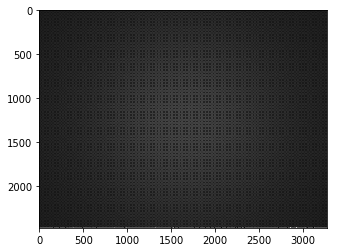

In [6]:
outimg = img.copy()
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
import raw_process4 as raw_process

In [9]:
from importlib import reload
reload(raw_process)

<module 'raw_process4' from '/home/moiz/work/raw_process/raw_process4.py'>

In [10]:
bayer_pattern = np.array([[2, 1], [1, 0]])

In [11]:
blacklevel = [64] * 4

In [12]:
blc_raw = raw_process.black_level_correction(img, blacklevel)

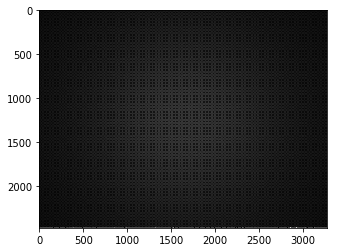

In [13]:
outimg = blc_raw.copy()
outimg = outimg.reshape((h, w))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')

In [56]:
white_point = np.array([blc_raw[1::2, 1::2].mean(), 
                        (blc_raw[0::2, 1::2].mean() + blc_raw[1::2, 0::2].mean())/2, 
                        blc_raw[0::2, 0::2].mean()])
wbg = white_point.max() / white_point
print(wbg)

[1.24450787 1.         2.39462698]


In [68]:
wbg = np.array([1.105, 1, 2.609, 1])

In [69]:
wb_raw = raw_process.white_balance_Bayer(blc_raw, wbg, bayer_pattern)

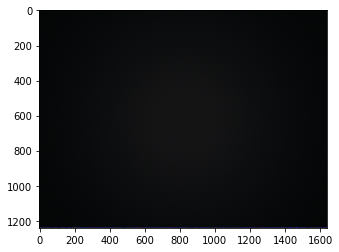

In [70]:
outimg = raw_process.preview_demosaic(wb_raw, bayer_pattern)
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg, cmap='gray')

In [71]:
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)

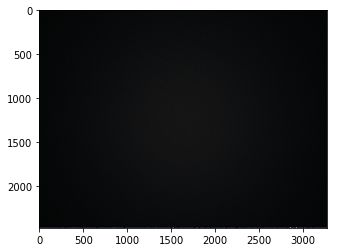

In [72]:
outimg = dms_img.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
outimg = outimg / outimg.max()
imshow(outimg)

In [78]:
ccm_matrix = (6022,-2314,394,-936,4728,310,300,-4324,8126)
img_ccm = raw_process.color_correction_matrix(dms_img, ccm_matrix)

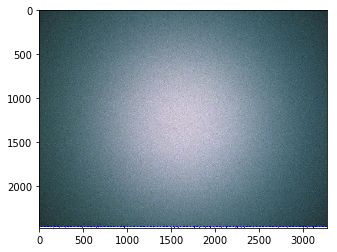

In [83]:
outimg = img_ccm.copy()
outimg = outimg.reshape((h, w, 3))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
imshow(outimg)

In [92]:
img_ccm[img_ccm > 1023] = 1023
img_gamma = raw_process.gamma_correction(img_ccm, 2.2)

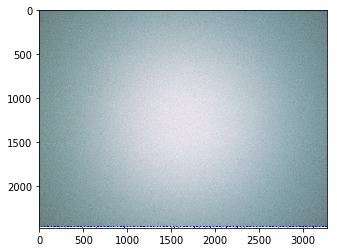

In [93]:
outimg = img_gamma.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
imshow(outimg)

In [86]:
raw_process.write(img_gamma, "raspi_raw_out.png")

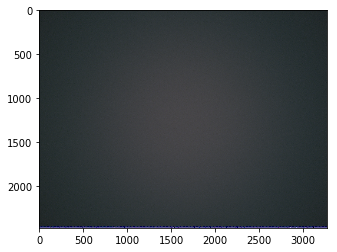

In [87]:
import imageio
from pylab import imshow, show
imshow(imageio.imread('raspi_raw_out.png'))
show()